In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_log_error

In [2]:
# Import data
train = 'https://raw.githubusercontent.com/ss16318/AML_Group_3/main/train.csv'
df_train_raw = pd.read_csv(train)

test_x = 'https://raw.githubusercontent.com/ss16318/AML_Group_3/main/test.csv'
df_test_x_raw = pd.read_csv(test_x)

test_y = 'https://raw.githubusercontent.com/ss16318/AML_Group_3/main/sample_submission.csv'
df_test_y_raw= pd.read_csv(test_y)

In [3]:
# Merge train dataset and test dataset
df_test_raw = pd.merge(df_test_x_raw, df_test_y_raw, on='Id')
df_raw = pd.concat([df_train_raw,df_test_raw])


In [4]:
df_raw

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.000000
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.000000
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.000000
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.000000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,167081.220949
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,164788.778231
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,219222.423400
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,184924.279659


In [5]:
# In the data description, missing values(nan) for those features are indicated None
na_none = ['Alley','BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 
     'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']

In [6]:
# check percentage of missing data for each feature in train dataset
na_col = [i for i in df_raw.columns if df_raw[i].isnull().sum() > 0 and i not in na_none]
print((df_raw[na_col].isna().sum()/len(df_raw.Id)).sort_values())

BsmtUnfSF       0.000343
GarageCars      0.000343
KitchenQual     0.000343
Electrical      0.000343
TotalBsmtSF     0.000343
GarageArea      0.000343
BsmtFinSF2      0.000343
SaleType        0.000343
Exterior2nd     0.000343
Exterior1st     0.000343
BsmtFinSF1      0.000343
BsmtFullBath    0.000685
BsmtHalfBath    0.000685
Utilities       0.000685
Functional      0.000685
MSZoning        0.001370
MasVnrArea      0.007879
MasVnrType      0.008222
GarageYrBlt     0.054471
LotFrontage     0.166495
dtype: float64


In [7]:
def clean_df(df):
    for col in df.columns:
        if col in na_none:
            df[col] =  df[col].fillna('None')
        elif df[col].isnull().sum() / df.shape[0] > 0.1:
            df = df.drop(col, axis=1)
        elif df[col].isnull().sum() / df.shape[0] <= 0.1:
            df = df.dropna(subset=[col])
    return df

In [8]:
df = clean_df(df_raw)
df = df.drop('Id', axis=1)

In [9]:
# split the dataset
df_x = df.drop(columns='SalePrice')
df_y = df['SalePrice']

In [10]:
## Seb Encoding, Correlation and Clustering

#List categorical features
categorical_feats = df_x.select_dtypes('object').columns
categorical_feats

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [11]:
# Encode variables

# Target Encode features that have many groups / are not ordinal
target_cat_feats = ['GarageType', 'Functional', 'Electrical', 'SaleCondition', 'SaleType', 'Heating', 'BsmtFinType2', 'BsmtFinType1', 'Foundation', 'MSZoning', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType']
target_encoder = ce.TargetEncoder(cols=target_cat_feats)

target_encoder.fit(df_x, df_y)
df_x_te = target_encoder.transform(df_x)

# Ordinal Encode features with few groups / have a natural order
ordinal_cat_feats = ['FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature', 'Alley', 'KitchenQual', 'PavedDrive', 'GarageCond', 'GarageQual', 'GarageFinish', 'CentralAir', 'HeatingQC', 'BsmtExposure', 'BsmtCond', 'BsmtQual', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LandSlope', 'ExterQual', 'ExterCond']
ordinal_encoder = ce.OrdinalEncoder(cols=ordinal_cat_feats)

ordinal_encoder.fit(df_x_te, df_y)
df_x_encoded = ordinal_encoder.transform(df_x_te)

In [12]:
df_x_encoded

,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,188216.590793,8450,1,1,1,1,1,179629.124775,1,...,0,0,1,1,1,0,2,2008,178231.141232,178717.795783
1,20,188216.590793,9600,1,1,1,1,1,181436.760833,1,...,0,0,1,1,1,0,5,2007,178231.141232,178717.795783
2,60,188216.590793,11250,1,1,2,1,1,179629.124775,1,...,0,0,1,1,1,0,9,2008,178231.141232,178717.795783
3,70,188216.590793,9550,1,1,2,1,1,182996.979724,1,...,0,0,1,1,1,0,2,2006,178231.141232,165527.980749
4,60,188216.590793,14260,1,1,2,1,1,181436.760833,1,...,0,0,1,1,1,0,12,2008,178231.141232,178717.795783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,20,188216.590793,13384,1,1,1,1,1,179629.124775,2,...,0,0,1,1,1,0,5,2006,178231.141232,178717.795783
1452,160,151286.299685,1533,1,1,1,1,1,179629.124775,1,...,0,0,1,1,1,0,12,2006,178231.141232,165527.980749
1455,160,151286.299685,1894,1,1,1,1,1,179629.124775,1,...,0,0,1,1,1,0,4,2006,178231.141232,165527.980749
1456,20,188216.590793,20000,1,1,1,1,1,179629.124775,1,...,0,0,1,1,1,0,9,2006,178231.141232,165527.980749


In [13]:
# Sort Data Chronologically (preventing data leakage)
df_x_encoded = df_x_encoded.reset_index(drop=True)
df_y = df_y.reset_index(drop=True)

# Sort df_x_encoded by YearSold
df_x_sorted = df_x_encoded.sort_values(by='YrSold')

# Set the index of df_y to match the sorted index of df_x_sorted
df_y_sorted = df_y.loc[df_x_sorted.index]

In [14]:

# Split Data into Dev and Test
X_dev, X_test, y_dev, y_test = train_test_split(df_x_sorted, df_y_sorted, test_size=0.2, shuffle=False)

# Split Dev into Train and Test
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.2, shuffle=False)

In [15]:
#Scale Data
scale = StandardScaler()
X_train_scaled = scale.fit_transform(X_train)
X_val_scaled = scale.transform(X_val)
X_test_scaled = scale.fit_transform(X_test)

### PCA (Ilan)

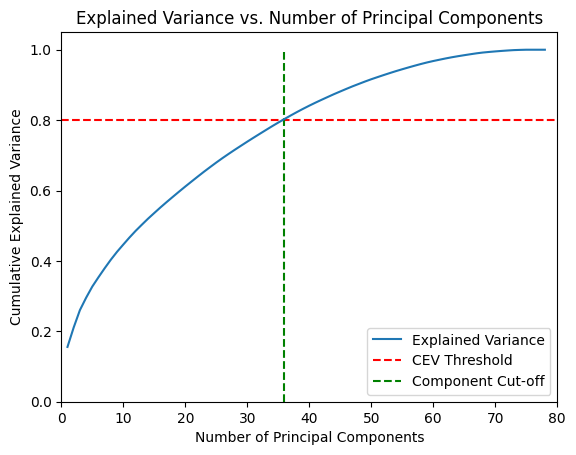

In [16]:
from sklearn.decomposition import PCA

#Apply PCA to scaled data and compute the variance ratio:
pca = PCA()
pca.fit(X_train_scaled)
explained_variance_ratio = pca.explained_variance_ratio_

#Plot the explained variance ratio as a function of the number of principal components:
plt.plot(range(1, len(explained_variance_ratio) + 1), np.cumsum(explained_variance_ratio), label='Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.hlines(y=0.8, xmin=0, xmax=80, linestyles='dashed', colors='red', label='CEV Threshold')
plt.vlines(x=36, ymin=0, ymax=1, linestyles='dashed', colors='green', label='Component Cut-off')
plt.xlim((0,80))
plt.ylim((0,1.05))
plt.legend(loc='lower right')
plt.title('Explained Variance vs. Number of Principal Components')
plt.show()

In [17]:
#Determine the number of PC that explain a sufficient proportion of the variance
n_components = np.where(np.cumsum(explained_variance_ratio) >= 0.80)[0][0] + 1

In [18]:
#Perform PCA with the optimal number of principal components:
pca_optimal = PCA(n_components=n_components)

X_train_pca = pca_optimal.fit_transform(X_train_scaled)
X_val_pca = pca_optimal.fit_transform(X_val_scaled)
X_test_pca = pca_optimal.fit_transform(X_test_scaled)

In [19]:
# Create a DataFrame with principal components and columns named 'PC1', 'PC2', etc.
df_principal_components = pd.DataFrame(X_train_pca, columns=['PC' + str(i + 1) for i in range(n_components)])
df_principal_components

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36
0,2.434802,0.678556,1.673802,-1.009297,1.041777,0.954326,-1.261555,-1.147691,0.586423,1.142937,...,0.143281,0.467746,0.393587,-0.470188,-1.149030,-0.449835,1.115173,-1.293991,0.840875,-0.397055
1,-3.282257,-0.557697,-1.479072,-0.951685,-0.563469,2.765996,0.570950,0.686599,-0.221575,0.869572,...,-0.485477,-0.418605,-2.266265,-0.112518,-0.592446,0.720890,0.467383,-1.936299,-0.638712,0.538235
2,3.240687,-1.633701,1.900760,-1.645603,0.144242,-0.066543,0.030860,-0.197406,0.174450,-0.382717,...,0.556918,0.259958,0.056643,0.407729,-0.269496,0.425553,-0.135618,-0.117520,0.005968,0.345284
3,-1.099792,0.347952,-1.021691,-0.532841,-0.614978,0.402116,-0.317639,1.148247,-0.918970,0.012260,...,0.866539,-0.418356,0.294735,0.072384,1.157805,-0.579862,-0.365721,-0.063254,1.427320,-0.210782
4,-0.045693,0.514078,1.552284,0.187640,0.213832,1.504642,-0.060946,0.076300,-0.436409,-0.387897,...,1.563549,-0.621125,-0.977098,-0.012471,-0.007393,-0.494056,-0.203699,0.634777,-0.844023,1.413485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,-1.476121,1.302193,3.138262,-2.391503,0.274784,-2.274858,-0.986070,-1.094617,1.803021,1.843151,...,0.410642,-4.307398,-0.284533,1.668649,-2.104243,4.058060,-3.041506,-0.919936,0.439102,1.330534
1740,0.011756,1.776977,-1.111169,-1.300791,-0.210105,0.145719,0.263171,1.165539,-0.071769,-0.412733,...,-0.771074,-0.597575,-0.100189,1.335367,1.309915,-1.512144,-0.692741,0.919752,0.976127,0.373540
1741,-4.785568,-0.576495,0.256698,2.447869,-0.466529,-1.257691,0.678384,-1.832591,1.764955,-0.378903,...,0.137544,0.996911,0.538621,1.925145,1.079147,-0.277678,0.997322,-0.861988,-1.284510,-0.048542
1742,-4.320465,-0.007264,0.576566,3.211099,-0.281508,-2.722599,3.317479,-5.274216,0.210213,-4.040576,...,-1.995223,-1.775982,-0.346409,-2.380999,-2.383799,-2.666856,0.698799,-4.028224,0.355704,0.483044


### Linear regression on original data

In [20]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [21]:
linear = LinearRegression()
linear.fit(X_train, y_train)

print("RMSLE: ", np.sqrt(mean_squared_log_error(y_test, linear.predict(X_test))))

RMSLE:  0.19146627639046834


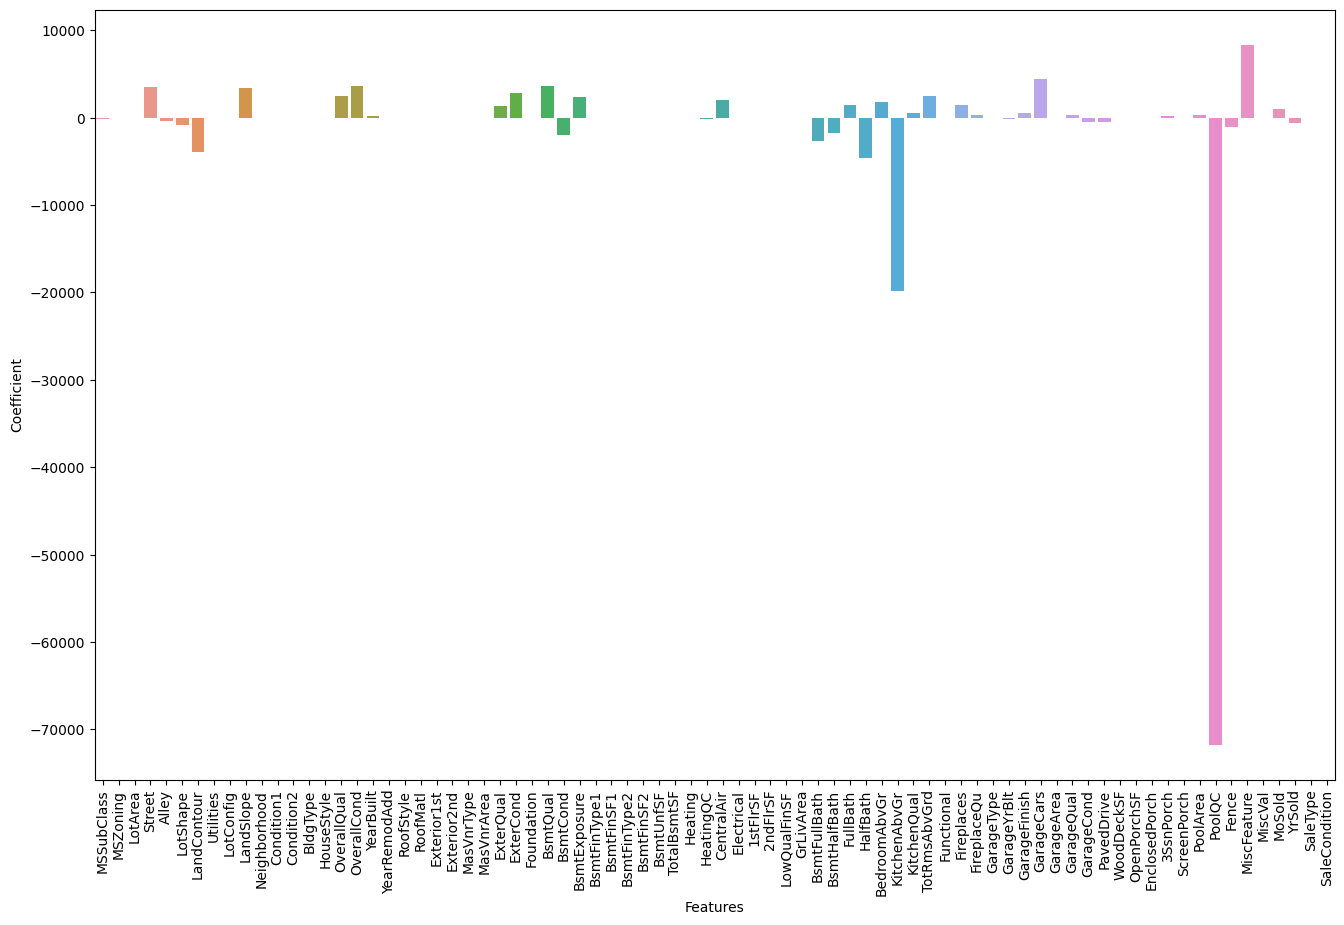

In [22]:
# plot feature importance
fig = plt.figure(figsize=(16,10))
linear_coefs = linear.coef_
names = df_x.columns.to_list()
ax = sns.barplot(x=names, y=linear_coefs)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Coefficient")
plt.show()

### LASSO regression on original data

In [23]:
lasso = Lasso(random_state=0)
lasso_alpha = {'alpha': np.logspace(-5, 2, 20)}
grid_search_lasso = GridSearchCV(lasso, lasso_alpha)
grid_search_lasso.fit(X_val, y_val)

print("Best hyperparameters: ", grid_search_lasso.best_params_)

best_lasso = Lasso(alpha=grid_search_lasso.best_params_['alpha'], random_state=0)
best_lasso.fit(X_train, y_train)

print("RMSLE: ", np.sqrt(mean_squared_log_error(y_test, best_lasso.predict(X_test))))


Best hyperparameters:  {'alpha': 100.0}
RMSLE:  0.1904458574787981


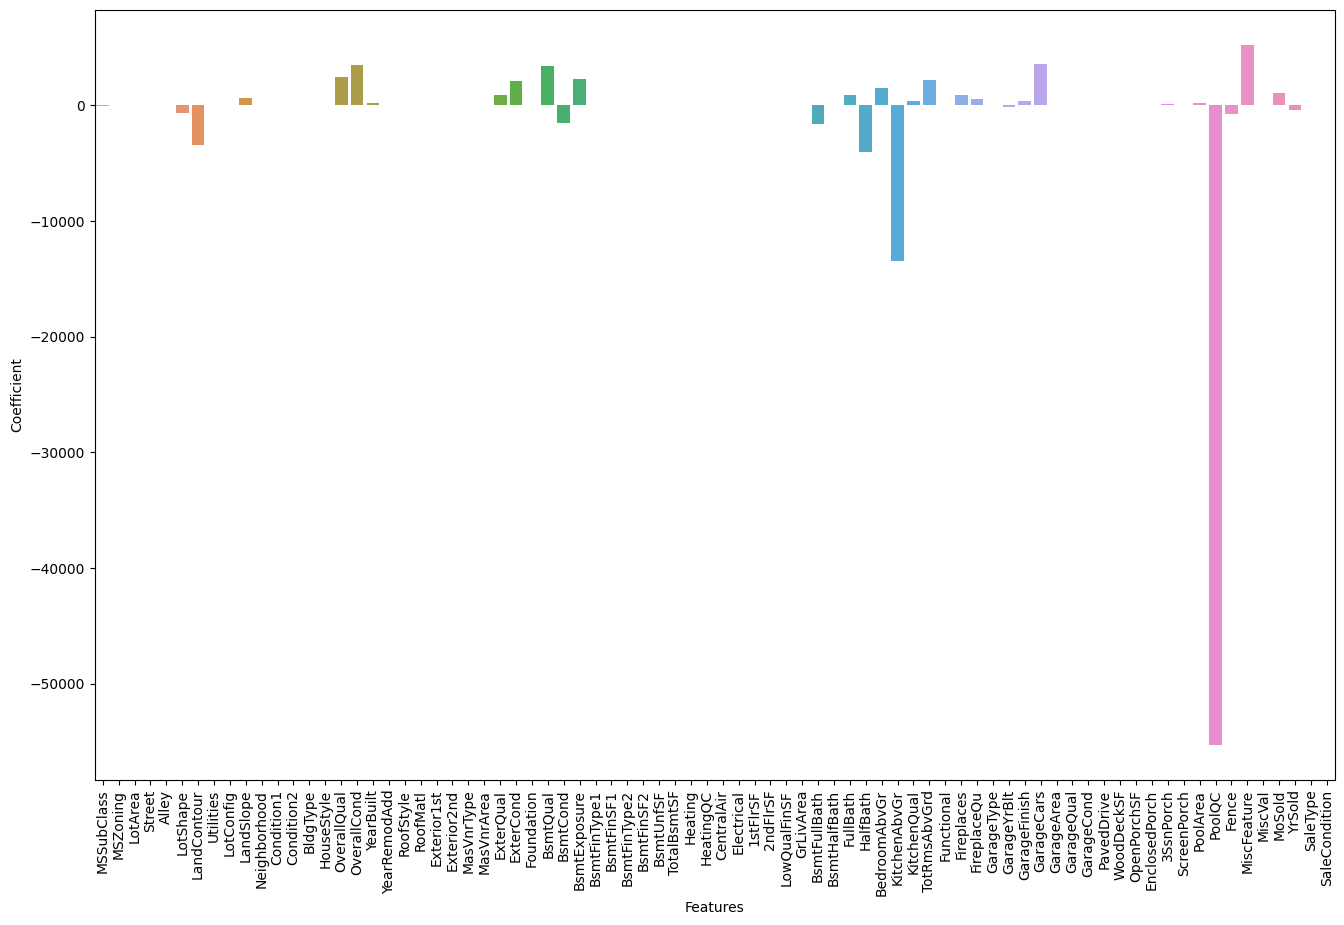

In [24]:
# plot feature importance
fig = plt.figure(figsize= (16,10))
lasso_coefs = best_lasso.coef_
names = df_x.columns.to_list()
ax = sns.barplot(x=names, y=lasso_coefs)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Coefficient")
plt.show()

### Linear regression using Principal Components

In [25]:
linear_pca = LinearRegression()
linear_pca.fit(X_train_pca, y_train)

print("RMSLE: ", np.sqrt(mean_squared_log_error(y_test, linear_pca.predict(X_test_pca))))

RMSLE:  0.3826641687467447


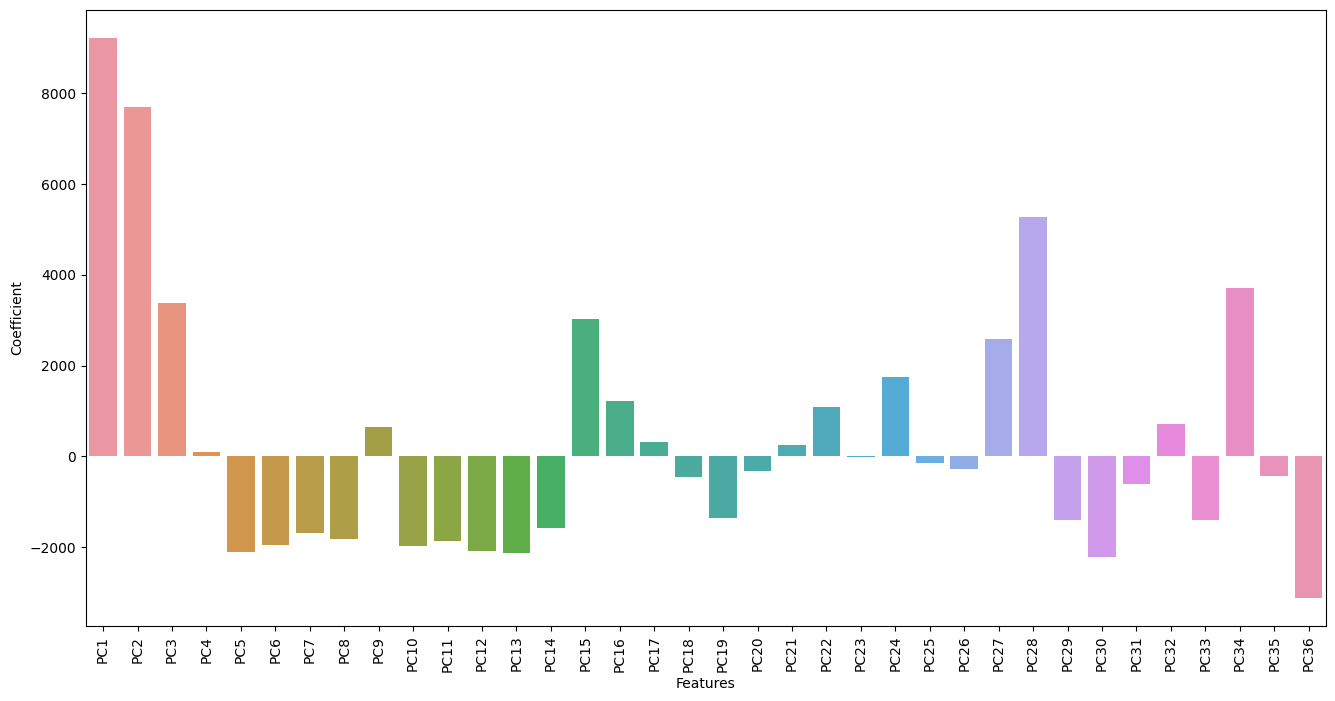

In [26]:
# plot feature importance
fig = plt.figure(figsize= (16,8))
linear_coefs_pca = linear_pca.coef_
names = df_principal_components.columns.to_list()
ax = sns.barplot(x=names, y=linear_coefs_pca)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Coefficient")
plt.show()

### LASSO regression using Principal Components

In [27]:
# lasso = Lasso(random_state=0)
# lasso_alpha = {'alpha': np.logspace(-5, 2, 20)}
grid_search_lasso_pca = GridSearchCV(lasso, lasso_alpha)
grid_search_lasso_pca.fit(X_val_pca, y_val)

print("Best hyperparameters: ", grid_search_lasso_pca.best_params_)

best_lasso_pca = Lasso(alpha=grid_search_lasso_pca.best_params_['alpha'], random_state=0)
best_lasso_pca.fit(X_train_pca, y_train)

print("RMSLE: ", np.sqrt(mean_squared_log_error(y_test, best_lasso_pca.predict(X_test_pca))))

Best hyperparameters:  {'alpha': 100.0}
RMSLE:  0.38225863531985693


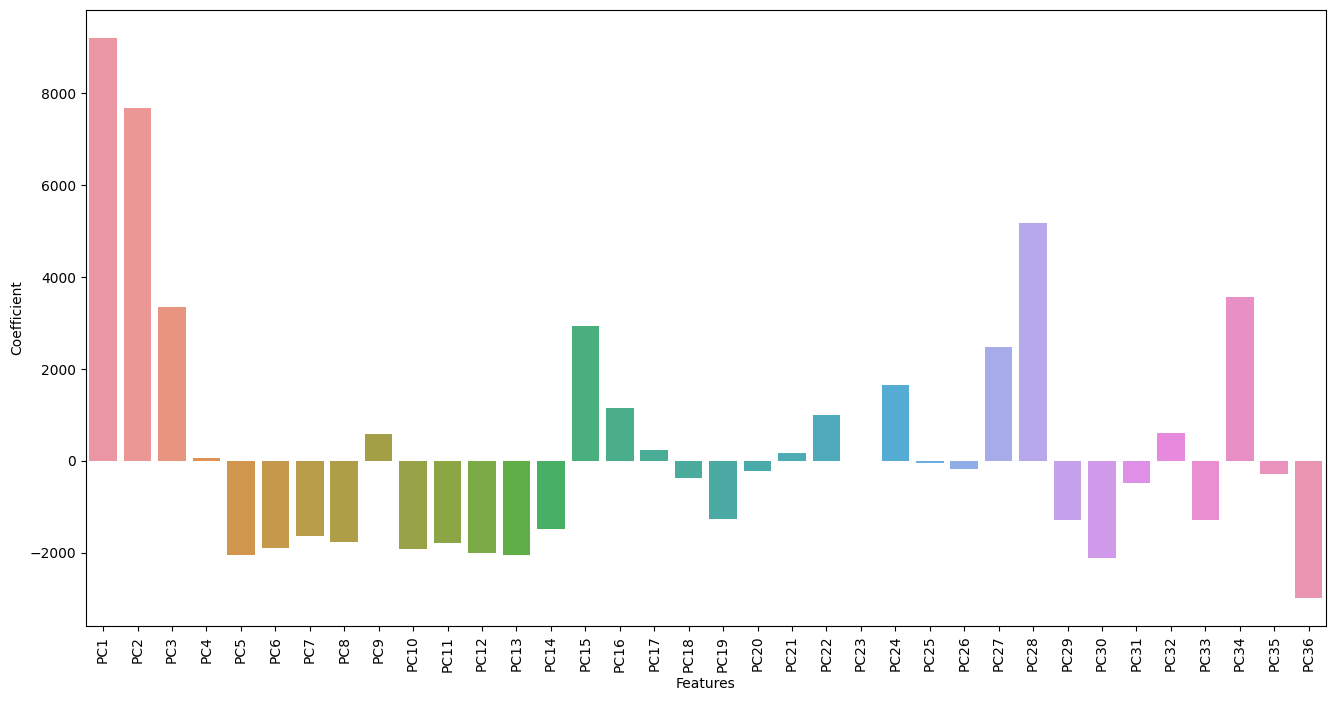

In [28]:
# plot feature importance
fig = plt.figure(figsize= (16,8))
lasso_coefs_pca = best_lasso_pca.coef_
names = df_principal_components.columns.to_list()
ax = sns.barplot(x=names, y=lasso_coefs_pca)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Coefficient")
plt.show()

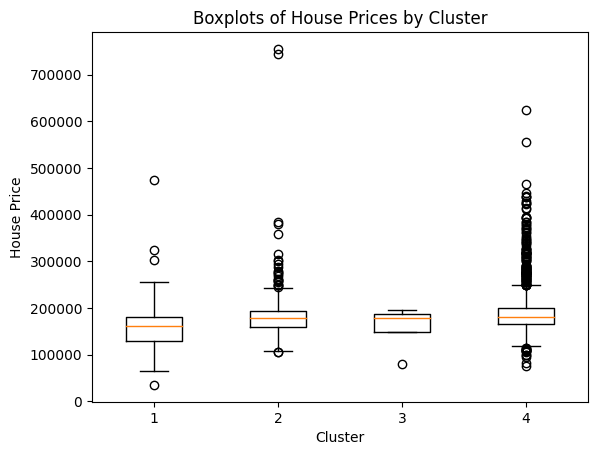

Cluster 1: 393 data points
Cluster 2: 349 data points
Cluster 3: 5 data points
Cluster 4: 997 data points


In [36]:
from sklearn.mixture import GaussianMixture

#Gaussian Mixture Modelling
gmm = GaussianMixture(n_components=4, random_state=42)
gmm.fit(X_train_scaled)

# Predict the labels for the data
labels = gmm.predict(X_train_scaled)

# Create a list of y values for each cluster
y_cluster = [y_train[labels == i] for i in range(gmm.n_components)]

# Sort clusters in ascending order (by median)
sorted_y_cluster = sorted(y_cluster, key=lambda x: np.median(x))

# Boxplot of clusters
plt.boxplot(sorted_y_cluster)
plt.title("Boxplots of House Prices by Cluster")
plt.xlabel("Cluster")
plt.ylabel("House Price")
plt.show()

# Count number of points in each cluster
for i in range(0,len(sorted_y_cluster)):
    print("Cluster " + str(i+1) + ": " + str(len(sorted_y_cluster[i])) + " data points")  

In [40]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
import matplotlib.pyplot as plt
import numpy as np

# Initialize a list to store the RMSLE for each cluster-specific model
rmsle_list = []

# Loop through each cluster
for i in range(gmm.n_components):
    # Get the indices of the samples belonging to the current cluster
    cluster_indices = np.where(labels == i)[0]

    # Split the data into training and testing sets for the current cluster
    X_cluster_train, X_cluster_test, y_cluster_train, y_cluster_test = train_test_split(
        X_train.iloc[cluster_indices], y_train.iloc[cluster_indices], test_size=0.2, random_state=42)

    # Train a linear regression model for the current cluster
    linear_cluster = LinearRegression()
    linear_cluster.fit(X_cluster_train, y_cluster_train)

    # Calculate the RMSLE for the current cluster-specific model
    y_pred = linear_cluster.predict(X_cluster_test)
    y_pred_clipped = np.clip(y_pred, 0, None)
    rmsle = np.sqrt(mean_squared_log_error(y_cluster_test, y_pred_clipped))

    rmsle_list.append(rmsle)
    print(f"Cluster {i+1} RMSLE: {rmsle}")

# Calculate the average RMSLE across all cluster-specific models
average_rmsle = np.mean(rmsle_list)
print(f"Average RMSLE for cluster-specific models: {average_rmsle}")

# Compare the average RMSLE with the baseline RMSLE
baseline_rmsle = np.sqrt(mean_squared_log_error(y_test, linear.predict(X_test)))
print(f"Baseline RMSLE: {baseline_rmsle}")

Cluster 1 RMSLE: 0.2613436844188014
Cluster 2 RMSLE: 0.1864920932415385
Cluster 3 RMSLE: 0.2136397395189924
Cluster 4 RMSLE: 1.4615654210676097
Average RMSLE for cluster-specific models: 0.5307602345617355
Baseline RMSLE: 0.19146627639046834


Based on the results you provided, the cluster-specific linear regression models have a higher average RMSLE (0.5308) compared to the baseline linear regression model (0.1915). This indicates that the group-specific regression for each cluster found in the GMM does not enhance the performance compared to the linear regression on the original data in this case.

One possible reason for this outcome is that the GMM clustering is not effectively capturing the underlying structure of the data in a way that benefits the prediction of house prices. Another reason could be the presence of a cluster with a particularly high RMSLE (Cluster 4) which is skewing the average RMSLE upwards. You could try experimenting with different clustering techniques or varying the number of clusters to see if you can obtain better results.

In [41]:
# Initialize a list to store the RMSLE for each cluster-specific model
rmsle_list = []

# Loop through each cluster, excluding Cluster 4
for i in range(gmm.n_components - 1):  # Change the loop range to exclude the last cluster
    # Get the indices of the samples belonging to the current cluster
    cluster_indices = np.where(labels == i)[0]

    # Split the data into training and testing sets for the current cluster
    X_cluster_train, X_cluster_test, y_cluster_train, y_cluster_test = train_test_split(
        X_train.iloc[cluster_indices], y_train.iloc[cluster_indices], test_size=0.2, random_state=42)

    # Train a linear regression model for the current cluster
    linear_cluster = LinearRegression()
    linear_cluster.fit(X_cluster_train, y_cluster_train)

    # Calculate the RMSLE for the current cluster-specific model
    y_pred = linear_cluster.predict(X_cluster_test)
    y_pred_clipped = np.clip(y_pred, 0, None)
    rmsle = np.sqrt(mean_squared_log_error(y_cluster_test, y_pred_clipped))

    rmsle_list.append(rmsle)
    print(f"Cluster {i+1} RMSLE: {rmsle}")

# Calculate the average RMSLE across all cluster-specific models, excluding Cluster 4
average_rmsle_without_cluster4 = np.mean(rmsle_list)
print(f"Average RMSLE for cluster-specific models without Cluster 4: {average_rmsle_without_cluster4}")

# Compare the average RMSLE without Cluster 4 with the baseline RMSLE
print(f"Baseline RMSLE: {baseline_rmsle}")


Cluster 1 RMSLE: 0.2613436844188014
Cluster 2 RMSLE: 0.1864920932415385
Cluster 3 RMSLE: 0.2136397395189924
Average RMSLE for cluster-specific models without Cluster 4: 0.22049183905977743
Baseline RMSLE: 0.19146627639046834


Based on the updated results without Cluster 4, the average RMSLE for the cluster-specific linear regression models is 0.2205, which is still higher than the baseline RMSLE of 0.1915. This indicates that even without considering Cluster 4, the group-specific regression for each cluster found in the GMM does not enhance the performance compared to the linear regression on the original data.

This could be because the GMM clustering is still not effectively capturing the underlying structure of the data in a way that benefits the prediction of house prices. It may be worth exploring other clustering techniques, varying the number of clusters, or even trying different regression algorithms to see if you can obtain better results.

In [46]:
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error, silhouette_score
from sklearn.model_selection import train_test_split

# Scaling your data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define clustering algorithms with their specific parameters
clustering_algorithms = {
    'KMeans': {'algorithm': KMeans, 'params': {'n_clusters': None, 'random_state': 42}},
    'AgglomerativeClustering': {'algorithm': AgglomerativeClustering, 'params': {'n_clusters': None}},
    'GaussianMixture': {'algorithm': GaussianMixture, 'params': {'n_components': None, 'random_state': 42}}
}


# Define regression algorithms
regression_algorithms = {
    'LinearRegression': LinearRegression,
    'Ridge': Ridge,
    'SVR': SVR,
    'RandomForestRegressor': RandomForestRegressor
}

# Define the range of the number of clusters to explore
n_clusters_range = range(2, 11)

# Initialize variables to store the best model information
best_rmsle = float('inf')
best_clustering = None
best_n_clusters = None
best_regression = None

# Loop through each clustering algorithm
for clustering_name, clustering_info in clustering_algorithms.items():
    # Loop through the range of the number of clusters
    for n_clusters in n_clusters_range:
        # Set the appropriate parameter for the number of clusters or components
        if clustering_name == 'GaussianMixture':
            clustering_info['params']['n_components'] = n_clusters
        else:
            clustering_info['params']['n_clusters'] = n_clusters

        # Initialize the clustering algorithm with the current number of clusters and specific parameters
        clustering = clustering_info['algorithm'](**clustering_info['params'])

        # Fit the clustering algorithm to the training data and predict the labels
        if clustering_name == 'GaussianMixture':
            clustering.fit(X_train_scaled)
            labels = clustering.predict(X_train_scaled)
        else:
            labels = clustering.fit_predict(X_train_scaled)
        
        # Calculate the silhouette score for the current clustering
        silhouette_avg = silhouette_score(X_train_scaled, labels)
        
        # Loop through each regression algorithm
        for regression_name, Regression in regression_algorithms.items():
            # Initialize a list to store the RMSLE for each cluster-specific model
            rmsle_list = []
            
            # Loop through each cluster
            for i in range(n_clusters):
                # Get the indices of the samples belonging to the current cluster
                cluster_indices = np.where(labels == i)[0]

                # Split the data into training and testing sets for the current cluster
                X_cluster_train, X_cluster_test, y_cluster_train, y_cluster_test = train_test_split(
                    X_train.iloc[cluster_indices], y_train.iloc[cluster_indices], test_size=0.2, random_state=42)

                # Train a regression model for the current cluster
                regression = Regression()
                regression.fit(X_cluster_train, y_cluster_train)

                # Calculate the RMSLE for the current cluster-specific model
                y_pred = regression.predict(X_cluster_test)
                y_pred_clipped = np.clip(y_pred, 0, None)
                rmsle = np.sqrt(mean_squared_log_error(y_cluster_test, y_pred_clipped))

                rmsle_list.append(rmsle)

            # Calculate the average RMSLE across all cluster-specific models
            average_rmsle = np.mean(rmsle_list)
            
            # Update the best model information if the current combination has a lower average RMSLE
            if average_rmsle < best_rmsle:
                best_rmsle = average_rmsle
                best_clustering = clustering_name
                best_n_clusters = n_clusters
                best_regression = regression_name

            print(f"{clustering_name} with {n_clusters} clusters and {regression_name}: Average RMSLE = {average_rmsle:.4f}, Silhouette Score = {silhouette_avg:.4f}")

# Print the best model information
print(f"\nBest combination: {best_clustering} with {best_n_clusters} clusters and {best_regression}")
print(f"Best average RMSLE: {best_rmsle:.4f}")


/Users/ilangabsi/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans with 2 clusters and LinearRegression: Average RMSLE = 0.2159, Silhouette Score = 0.1222
KMeans with 2 clusters and Ridge: Average RMSLE = 0.2151, Silhouette Score = 0.1222
KMeans with 2 clusters and SVR: Average RMSLE = 0.2460, Silhouette Score = 0.1222
KMeans with 2 clusters and RandomForestRegressor: Average RMSLE = 0.2063, Silhouette Score = 0.1222


/Users/ilangabsi/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans with 3 clusters and LinearRegression: Average RMSLE = 0.2381, Silhouette Score = 0.0705
KMeans with 3 clusters and Ridge: Average RMSLE = 0.2322, Silhouette Score = 0.0705
KMeans with 3 clusters and SVR: Average RMSLE = 0.2395, Silhouette Score = 0.0705
KMeans with 3 clusters and RandomForestRegressor: Average RMSLE = 0.2082, Silhouette Score = 0.0705


/Users/ilangabsi/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans with 4 clusters and LinearRegression: Average RMSLE = 0.2539, Silhouette Score = 0.0674
KMeans with 4 clusters and Ridge: Average RMSLE = 0.2497, Silhouette Score = 0.0674
KMeans with 4 clusters and SVR: Average RMSLE = 0.2629, Silhouette Score = 0.0674
KMeans with 4 clusters and RandomForestRegressor: Average RMSLE = 0.2262, Silhouette Score = 0.0674


/Users/ilangabsi/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans with 5 clusters and LinearRegression: Average RMSLE = 0.2598, Silhouette Score = 0.0627
KMeans with 5 clusters and Ridge: Average RMSLE = 0.2449, Silhouette Score = 0.0627
KMeans with 5 clusters and SVR: Average RMSLE = 0.2433, Silhouette Score = 0.0627
KMeans with 5 clusters and RandomForestRegressor: Average RMSLE = 0.2121, Silhouette Score = 0.0627


/Users/ilangabsi/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans with 6 clusters and LinearRegression: Average RMSLE = 1.0105, Silhouette Score = 0.0620
KMeans with 6 clusters and Ridge: Average RMSLE = 0.4099, Silhouette Score = 0.0620
KMeans with 6 clusters and SVR: Average RMSLE = 0.3790, Silhouette Score = 0.0620
KMeans with 6 clusters and RandomForestRegressor: Average RMSLE = 0.3303, Silhouette Score = 0.0620


/Users/ilangabsi/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans with 7 clusters and LinearRegression: Average RMSLE = 1.6792, Silhouette Score = 0.0542
KMeans with 7 clusters and Ridge: Average RMSLE = 0.4179, Silhouette Score = 0.0542
KMeans with 7 clusters and SVR: Average RMSLE = 0.2535, Silhouette Score = 0.0542
KMeans with 7 clusters and RandomForestRegressor: Average RMSLE = 0.2195, Silhouette Score = 0.0542


/Users/ilangabsi/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans with 8 clusters and LinearRegression: Average RMSLE = 1.0999, Silhouette Score = 0.0551
KMeans with 8 clusters and Ridge: Average RMSLE = 1.0435, Silhouette Score = 0.0551
KMeans with 8 clusters and SVR: Average RMSLE = 0.3945, Silhouette Score = 0.0551
KMeans with 8 clusters and RandomForestRegressor: Average RMSLE = 0.3751, Silhouette Score = 0.0551


/Users/ilangabsi/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans with 9 clusters and LinearRegression: Average RMSLE = 1.4847, Silhouette Score = 0.0507
KMeans with 9 clusters and Ridge: Average RMSLE = 0.6337, Silhouette Score = 0.0507
KMeans with 9 clusters and SVR: Average RMSLE = 0.3337, Silhouette Score = 0.0507
KMeans with 9 clusters and RandomForestRegressor: Average RMSLE = 0.3146, Silhouette Score = 0.0507


/Users/ilangabsi/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans with 10 clusters and LinearRegression: Average RMSLE = 2.2128, Silhouette Score = 0.0469
KMeans with 10 clusters and Ridge: Average RMSLE = 0.6004, Silhouette Score = 0.0469
KMeans with 10 clusters and SVR: Average RMSLE = 0.3100, Silhouette Score = 0.0469
KMeans with 10 clusters and RandomForestRegressor: Average RMSLE = 0.2976, Silhouette Score = 0.0469
AgglomerativeClustering with 2 clusters and LinearRegression: Average RMSLE = 0.6567, Silhouette Score = 0.1006
AgglomerativeClustering with 2 clusters and Ridge: Average RMSLE = 0.6425, Silhouette Score = 0.1006
AgglomerativeClustering with 2 clusters and SVR: Average RMSLE = 0.2665, Silhouette Score = 0.1006
AgglomerativeClustering with 2 clusters and RandomForestRegressor: Average RMSLE = 0.2101, Silhouette Score = 0.1006
AgglomerativeClustering with 3 clusters and LinearRegression: Average RMSLE = 2.7372, Silhouette Score = 0.0981
AgglomerativeClustering with 3 clusters and Ridge: Average RMSLE = 2.7368, Silhouette Score = 